# <font color='blue'>Data Science Challenge @ ITA 2022</font>
# <font color='blue'>Equipe DIOMGIS</font>

## <font color='blue'>2º Fase</font>

### <font color='blue'>Construção de carteira composta por ativos que compõem o índice SP500.</font>

![title](data\image\logo.jpeg)

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.12


In [2]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
# Bibliotecas e Frameworks

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime
from hurst import compute_Hc, random_walk
from pykalman import KalmanFilter
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression

from sklearn.cluster import KMeans

In [4]:
# Versões dos pacotes usados neste jupyter notebook

%reload_ext watermark
%watermark -a "Equipe DIOMGIS" --iversions

Author: Equipe DIOMGIS

seaborn          : 0.11.2
pandas           : 1.4.2
matplotlib       : 3.5.1
numpy            : 1.22.3
pandas_datareader: 0.10.0



In [5]:
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams['figure.figsize'] = (15, 10)
sns.set_style("darkgrid")

In [6]:
# Parametros fixos de treinamento

quantAtivos = 10
verbose = 2
seed = 25
epochs = 2000
downloadData = False
timeBack = 500

np.random.seed(seed)

In [7]:
setores = {
    'Industrials': ['MMM', 'AOS', 'ALK', 'ALLE', 'AAL', 'AME', 'BA',
                    'CHRW', 'CARR', 'CAT', 'CTAS', 'CPRT', 'CSGP',
                    'CSX', 'CMI', 'DE', 'DAL', 'DOV', 'ETN', 'EMR',
                    'EFX', 'EXPD', 'FAST', 'FDX', 'FTV', 'FBHS',
                    'GNRC', 'GD', 'GE', 'HON', 'HWM', 'HII', 'IEX',
                    'ITW', 'IR', 'JBHT', 'J', 'JCI', 'LHX', 'LDOS',
                    'LMT', 'MAS', 'NDSN', 'NSC', 'NOC', 'ODFL',
                    'OTIS', 'PCAR', 'PH', 'PNR', 'PWR', 'RTX', 'RSG',
                    'RHI', 'ROK', 'ROL', 'SNA', 'LUV', 'SWK', 'TXT',
                    'TT', 'TDG', 'UNP', 'UAL', 'UPS', 'URI', 'VRSK',
                    'WAB', 'WM', 'GWW', 'XYL'],
    
    'HealthCare': ['ABT', 'ABBV', 'ABMD', 'A', 'ALGN', 'ABC', 'AMGN',
                   'BAX', 'BDX', 'BIO', 'TECH', 'BIIB', 'BSX', 'BMY',
                   'CAH', 'CTLT', 'CNC', 'CRL', 'CI', 'COO', 'CVS',
                   'DHR', 'DVA', 'XRAY', 'DXCM', 'EW', 'ELV', 'LLY',
                   'GILD', 'HCA', 'HSIC', 'HOLX', 'HUM', 'IDXX',
                   'ILMN', 'INCY', 'ISRG', 'IQV', 'JNJ', 'LH', 'MCK',
                   'MDT', 'MRK', 'MTD', 'MRNA', 'MOH', 'OGN', 'PKI',
                   'PFE', 'DGX', 'REGN', 'RMD', 'STE', 'SYK', 'TFX',
                   'TMO', 'UNH', 'UHS', 'VRTX', 'VTRS', 'WAT',
                   'WST', 'ZBH', 'ZTS'],
    
    'InformationTechnology': ['ACN', 'ADBE', 'ADP', 'AKAM', 'AMD', 'APH',
                              'ADI', 'ANSS', 'AAPL', 'AMAT', 'ANET', 'ADSK',
                              'AVGO', 'BR', 'CDNS', 'CDW', 'CDAY', 'CSCO',
                              'CTSH', 'GLW', 'DXC', 'ENPH', 'EPAM', 'FFIV',
                              'FIS', 'FISV', 'FLT', 'FTNT', 'IT', 'GPN',
                              'HPE', 'HPQ', 'IBM', 'INTC', 'INTU', 'JKHY',
                              'JNPR', 'KEYS', 'KLAC', 'LRCX', 'MA', 'MCHP',
                              'MU', 'MSFT', 'MPWR', 'MSI', 'NTAP', 'NLOK',
                              'NVDA', 'NXPI', 'ON', 'ORCL', 'PAYX', 'PAYC',
                              'PYPL', 'PTC', 'QRVO', 'QCOM', 'ROP', 'CRM',
                              'STX', 'NOW', 'SWKS', 'SEDG', 'SNPS', 'TEL',
                              'TDY', 'TER', 'TXN', 'TRMB', 'TYL', 'VRSN',
                              'V', 'WDC', 'ZBRA'],
    
    'CommunicationServices': ['ATVI', 'GOOGL', 'GOOG', 'T', 'CHTR', 'CMCSA',
                              'DISH', 'DIS', 'EA', 'FOXA', 'FOX', 'IPG', 'LYV',
                              'LUMN', 'MTCH', 'META', 'NFLX', 'NWSA', 'NWS',
                              'OMC', 'PARA', 'TMUS', 'TTWO', 'TWTR', 'VZ', 'WBD'],
    
    'ConsumerStaples': ['ADM', 'MO', 'BF.B', 'CPB', 'CHD', 'CLX', 'KO', 'CL',
                        'CAG', 'STZ', 'COST', 'EL', 'GIS', 'HSY', 'HRL', 'K',
                        'KDP', 'KMB', 'KHC', 'KR', 'LW', 'MKC', 'TAP', 'MDLZ',
                        'MNST', 'PEP', 'PM', 'PG', 'SJM', 'SYY', 'TSN', 'WBA',
                        'WMT'],
    
    'ConsumerDiscretionary': ['AAP', 'AMZN', 'APTV', 'AZO', 'BBWI',
                              'BBY', 'BKNG', 'BWA', 'CZR', 'KMX', 'CCL',
                              'CMG', 'DHI', 'DRI', 'DG', 'DLTR',
                              'DPZ', 'EBAY', 'ETSY', 'EXPE', 'F',
                              'GRMN', 'GM', 'GPC', 'HAS', 'HLT', 'HD',
                              'LVS', 'LEN', 'LKQ', 'LOW', 'MAR', 'MCD',
                              'MGM', 'MHK', 'NWL', 'NKE', 'NCLH', 'NVR',
                              'ORLY', 'POOL', 'PHM', 'RL', 'ROST', 'RCL',
                              'SBUX', 'TPR', 'TGT', 'TSLA', 'TJX',
                              'TSCO', 'ULTA', 'VFC', 'WHR', 'WYNN', 'YUM'],
    
    'Utilities': ['AES', 'LNT', 'AEE', 'AEP', 'AWK', 'ATO', 'CNP',
                  'CMS', 'ED', 'CEG', 'D', 'DTE', 'DUK', 'EIX',
                  'ETR', 'EVRG', 'ES', 'EXC', 'FE', 'NEE', 'NI',
                  'NRG', 'PCG', 'PNW', 'PPL', 'PEG', 'SRE', 'SO',
                  'WEC', 'XEL'],
    
    'Financials': ['AFL', 'ALL', 'AXP', 'AIG', 'AMP', 'AON', 'AJG',
                   'AIZ', 'BAC', 'WRB', 'BRK.B', 'BLK', 'BK', 'BRO',
                   'COF', 'CBOE', 'SCHW', 'CB', 'CINF', 'C', 'CFG',
                   'CME', 'CMA', 'DFS', 'RE', 'FDS', 'FITB', 'FRC',
                   'BEN', 'GL', 'GS', 'HIG', 'HBAN', 'ICE', 'IVZ',
                   'JPM', 'KEY', 'LNC', 'L', 'MTB', 'MKTX', 'MMC',
                   'MET', 'MCO', 'MS', 'MSCI', 'NDAQ', 'NTRS', 'PNC',
                   'PFG', 'PGR', 'PRU', 'RJF', 'RF', 'SPGI', 'SBNY',
                   'STT', 'SIVB', 'SYF', 'TROW', 'TRV', 'TFC',
                   'USB', 'WFC', 'WTW', 'ZION',  'NLSN'],
    
    'Materials': ['APD', 'ALB', 'AMCR', 'AVY', 'BALL', 'CE', 'CF',
                  'CTVA', 'DOW', 'DD', 'EMN', 'ECL', 'FMC', 'FCX',
                  'IP', 'IFF', 'LIN', 'LYB', 'MLM', 'MOS', 'NEM',
                  'NUE', 'PKG', 'PPG', 'SEE', 'SHW', 'VMC', 'WRK'],
    
    'RealEstate': ['ARE', 'AMT', 'AVB', 'BXP', 'CPT', 'CBRE', 'CCI',
                   'DLR', 'EQIX', 'EQR', 'ESS', 'EXR', 'FRT', 'PEAK',
                   'HST', 'INVH', 'IRM', 'KIM', 'MAA', 'PLD', 'PSA',
                   'O', 'REG', 'SBAC', 'SPG', 'UDR', 'VTR', 'VICI',
                   'VNO', 'WELL', 'WY'],
    
    'Energy': ['APA','BKR', 'CVX', 'COP', 'CTRA', 'DVN', 'FANG', 'EOG',
               'EQT', 'XOM', 'HAL', 'HES', 'KMI', 'MRO', 'MPC', 'OXY',
               'OKE', 'PSX', 'PXD', 'SLB', 'VLO', 'WMB']
}

In [8]:
ativos = []
for setor, empresas in setores.items():
    ativos.extend(empresas)
    
ativos.sort()

### Download dos Dados

In [9]:
if downloadData:

    start_date = "2017-10-21"
    end_date = "2022-10-21"

    data = web.DataReader(name = '^GSPC', data_source = 'yahoo', start = start_date, end = end_date)
    SP500_index = pd.DataFrame(data['Close']).reset_index().rename(columns={'Close': 'SP500', 'Date': 'Dia'})

    SP500_close = pd.DataFrame()

    for ativo in ativos:
  
        if ativo == 'BF.B':
            ativo = 'BF-B'

        if ativo == 'BRK.B':
            ativo = 'BRK-B'

        data = web.DataReader(name = ativo, data_source = 'yahoo', start = start_date, end = end_date)
        temp_close = pd.DataFrame(data['Close'])
        SP500_close = pd.concat([SP500_close, temp_close], axis = 1)

        
    SP500_close.columns = ativos
    SP500_close.reset_index(inplace = True)
    SP500_close.rename(columns={'Date': 'Dia'}, inplace = True)

    outdir = './data/{}-{}'.format(start_date, end_date)

    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    SP500_close.to_csv(path_or_buf = os.path.join(outdir, 'SP500_close'), index = False)
    SP500_index.to_csv(path_or_buf = os.path.join(outdir, 'SP500_index'), index = False)
    
else:
    SP500_close = pd.read_csv('./data/train/SP500Close.csv')
    SP500_close = SP500_close.set_index("Dia")
    SP500_close.index = pd.to_datetime(SP500_close.index)
    SP500_index = pd.read_csv('./data/train/SP500Index.csv')
    SP500_index = SP500_index.set_index("Dia")
    SP500_index.index = pd.to_datetime(SP500_index.index)

## Pré-Processamento dos Dados

In [10]:
df = SP500_close.copy()

In [11]:
df = df[df.index < '2019-10-20']
SP500_index = SP500_index[SP500_index.index < '2019-10-20']

In [12]:
df.isna().any().sum()

11

In [13]:
df = df.fillna(method = 'backfill', axis = 'columns')

In [14]:
df.isna().any().sum()

0

In [15]:
scaler = StandardScaler()

In [16]:
scaler.fit(df)

StandardScaler()

In [17]:
dfScalerNP = scaler.transform(df)

In [18]:
dfScaled = pd.DataFrame(dfScalerNP, columns = df.columns, index = df.index)

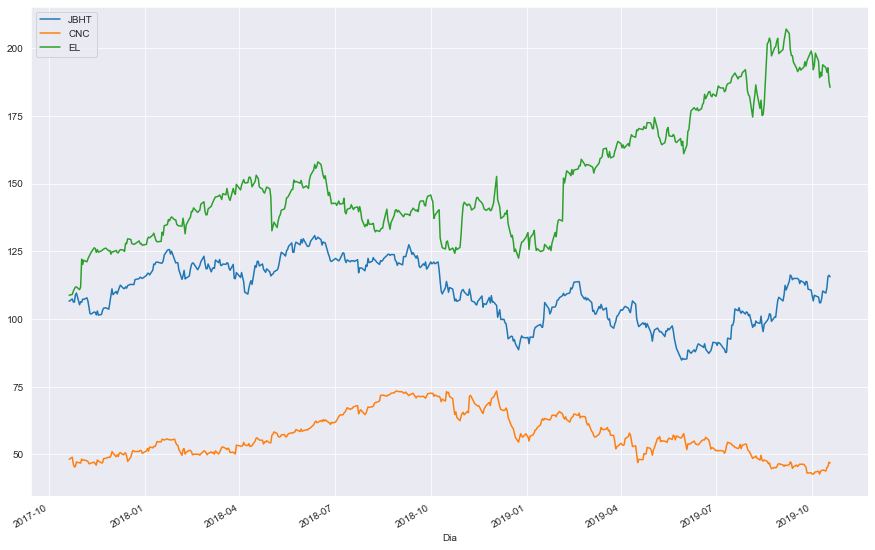

In [19]:
df.T.sample(3, random_state = 11).T.plot();

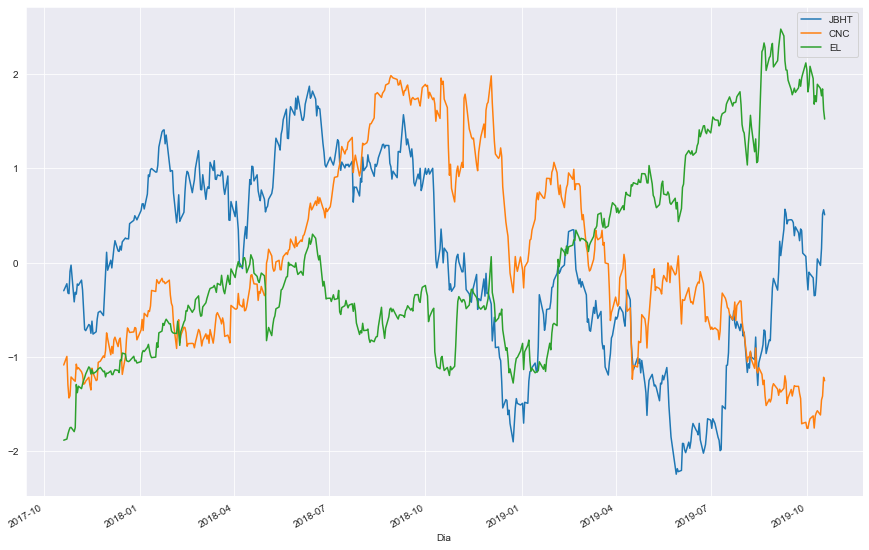

In [20]:
dfScaled.T.sample(3, random_state = 11).T.plot();

In [21]:
kmeans = KMeans(n_clusters = quantAtivos,
                n_init = 10 ,
                max_iter = 300,
                tol = 0.0001,
                verbose = 2,
                random_state = seed,
                algorithm = 'lloyd') # “lloyd”, “elkan”

In [22]:
kmeans.fit(dfScalerNP.T)

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Initialization complete
Iteration 0, inertia 113014.99771898838.
Iteration 1, inertia 78381.91131045256.
Iteration 2, inertia 74820.95373239544.
Iteration 3, inertia 73813.17775953663.
Iteration 4, inertia 73195.33489333969.
Iteration 5, inertia 72861.90755081606.
Iteration 6, inertia 72616.79001836444.
Iteration 7, inertia 72454.86926273786.
Iteration 8, inertia 72297.95050312855.
Iteration 9, inertia 72112.41264616749.
Iteration 10, inertia 71940.85519200307.
Iteration 11, inertia 71741.66421707535.
Iteration 12, inertia 71668.63577093526.
Iteration 13, inertia 71617.62334584534.
Iteration 14, inertia 71599.09423358766.
Iteration 15, inertia 71585.91507052616.
Iteration 16, inertia 71548.50000154125.
Iteration 17, inertia 71530.39037598373.
Iteration 18, inertia 71507.76982640466.
Iteration 19, inertia 71490.3949403622.
Iteration 20, inertia 71474.92689117948.
Iteration 21, inertia 71465.23844351048.
Iteration 22, inertia 71461.59112527296.
Iteration 23, inertia 71440.74476049498.
It

KMeans(n_clusters=10, random_state=25, verbose=2)

In [23]:
SP500IndexPct = SP500_index.pct_change().dropna()['SP500']

obs_matriz = np.expand_dims(np.vstack([[SP500IndexPct],
                                       [np.ones(len(SP500IndexPct))]]).T, axis = 1)

kf = KalmanFilter(initial_state_mean = [0, 0],
                  initial_state_covariance = np.ones((2, 2)),
                  transition_matrices = np.eye(2),
                  observation_matrices = obs_matriz)

In [24]:
selectGroup = []
ativosGroup = []
meanGroup = []
columns = []
regressAtivo = pd.DataFrame(index = ativos, columns = ['coefAng', 'RScore', 'Setor', "meanBeta", "H", "c", 'Group'])

x = np.arange(0, timeBack, 1, dtype = int).reshape(-1, 1)
time = datetime.now().strftime('%d-%B-%Ih%Mmin')

outdir = './graphics/2º Fase/{}'.format(time)

os.mkdir(outdir)
os.mkdir(outdir + '/ativos')

outdirtivos = outdir + '/ativos'
    
for i in range(quantAtivos):
    columns.append('Grupo {}'.format(i))
    
for group in np.unique(kmeans.labels_, return_counts=True)[0]:
    filter = kmeans.labels_ == group
    selectGroup.append(filter)
    ativosGroup.append(dfScaled.T[filter].index)
    meanGroup.append(dfScaled.T[filter].mean())
    
    
setorGroups = pd.DataFrame(np.zeros(shape = (len(setores), len(selectGroup)), dtype = int),
                           index = setores.keys(),
                           columns = columns)
    
for group in range(len(ativosGroup)):
    for ativo in ativosGroup[group]:
        for setor in setores.keys():
            if ativo in setores[setor]:
                setorGroups.loc[setor, setorGroups.columns[group]] += 1
                
                model = LinearRegression()
                aux = dfScaled[ativo].to_numpy().reshape(-1, 1)[-timeBack:]
                model.fit(x, aux)
                pred = model.predict(x)
                
                fig, ax = plt.subplots()
                ax.plot(dfScaled[ativo].index, dfScaled[ativo], linewidth=1.0, c = 'b')
                ax.plot(dfScaled[ativo].index[-timeBack:], pred, linewidth=2.0, c = 'r', ls = '--')
                nameGraphic = '{}.png'.format(ativo)
                fullname = os.path.join(outdirtivos, nameGraphic)
                plt.savefig(fullname)
                plt.close(fig)
                
                stateMeans, stateCovs = kf.filter(dfScaled[ativo].pct_change().dropna())
                H, c, data = compute_Hc(dfScaled[ativo].to_numpy() + 10, kind='price', simplified=True)
                
                regressAtivo.loc[ativo, 'RScore'] = model.score(x, aux)
                regressAtivo.loc[ativo, 'coefAng'] = model.coef_[0][0]
                regressAtivo.loc[ativo, 'Setor'] = setor
                regressAtivo.loc[ativo, "H"] = H
                regressAtivo.loc[ativo, "c"] = c
                regressAtivo.loc[ativo, "meanBeta"] = stateMeans[:, 0].mean()
                regressAtivo.loc[ativo, "Group"] = group

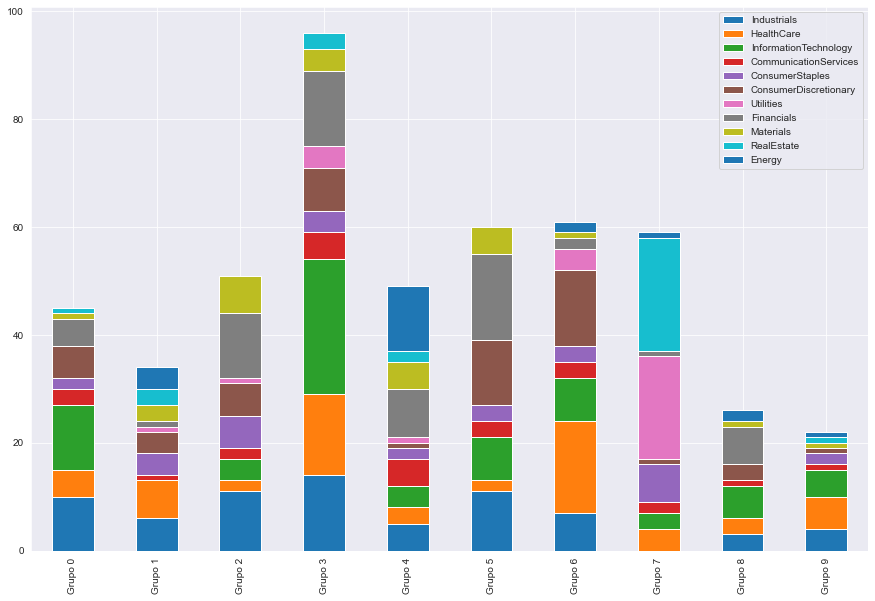

In [25]:
setorGroups.T.plot.bar(stacked=True);

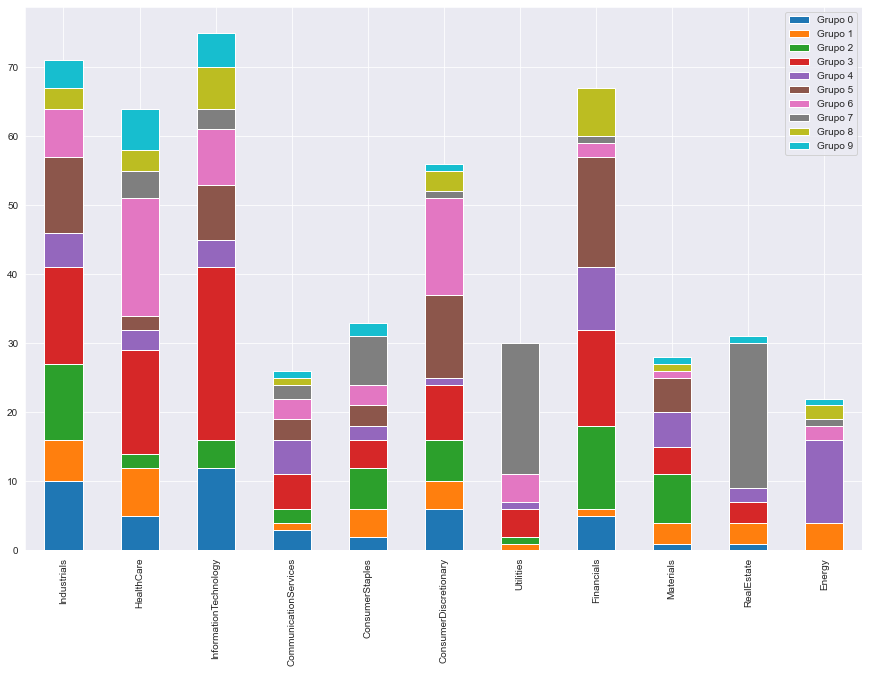

In [26]:
setorGroups.plot.bar(stacked=True);

In [27]:
mediaDF = pd.DataFrame(index = columns, columns = ["H", "c", "meanBeta"])
historicBeta = []

In [28]:
for group in range(quantAtivos):
    H, c, data = compute_Hc(meanGroup[group].to_numpy() + 10, kind='price', simplified=True)

    
    mediaDF.loc[mediaDF.index[group], "H"] = H
    mediaDF.loc[mediaDF.index[group], "c"] = c
    
    stateMeans, stateCovs = kf.filter(meanGroup[group].pct_change().dropna())
    
    mediaDF.loc[mediaDF.index[group], "meanBeta"] = stateMeans[:, 0].mean()
    historicBeta.append(stateMeans[:, 0])
    

    fig, ax = plt.subplots()
    ax.plot(SP500IndexPct.index, stateMeans[:, 0])
    ax.set_title("GRUPO {}".format(group))
    ax.set(xlabel='Data', ylabel = 'Coeficiente Beta')
    nameGraphic = '{} Coeficiente Beta.png'.format(group)
    fullname = os.path.join(outdir, nameGraphic)
    plt.savefig(fullname)
    plt.close(fig)
    
    stl = STL(meanGroup[group], period=365).fit()
    
    fig = stl.plot()
    ax.set_title("GRUPO {}".format(group))
    nameGraphic = '{} STL.png'.format(group)
    fullname = os.path.join(outdir, nameGraphic)
    plt.savefig(fullname)
    plt.close(fig)
       
    fig, ax = plt.subplots()
    dfScaled.T[selectGroup[group]].T.plot(ax = ax)
    ax.set_title("GRUPO {}".format(group))
    ax.set(xlabel='Data', ylabel='Preço Normalizado($)')
    nameGraphic = '{} Grupo.png'.format(group)
    fullname = os.path.join(outdir, nameGraphic)
    plt.savefig(fullname)
    plt.close(fig)
    
    fig, ax = plt.subplots()
    meanGroup[group].plot(ax = ax)
    ax.set_title("MEDIA GRUPAL {} / Expoente de Hurst: {:.3f}".format(group, H))
    ax.set(xlabel='Data', ylabel='Preço Normalizado($)')
    nameGraphic = '{} Media Grupal.png'.format(group)
    fullname = os.path.join(outdir, nameGraphic)
    plt.savefig(fullname)
    plt.close(fig)
#------------------------------------------------------------------------------------------------------------

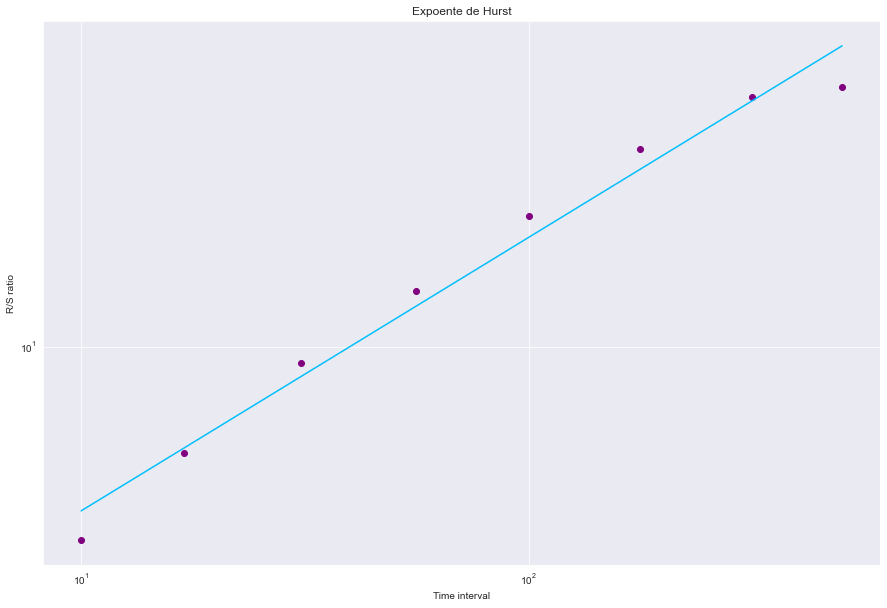

In [29]:
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_title("Expoente de Hurst")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

In [30]:
mediaDF

,H,c,meanBeta
Grupo 0,0.58131,1.177287,-22.907268
Grupo 1,0.611961,0.98818,19.623412
Grupo 2,0.65465,0.904334,3.415453
Grupo 3,0.600678,1.085709,34.628872
Grupo 4,0.628873,1.013017,-0.244343
Grupo 5,0.664505,0.902875,-1477.474197
Grupo 6,0.572046,1.25347,10.597955
Grupo 7,0.559172,1.128813,0.622169
Grupo 8,0.566089,1.240053,45.965689
Grupo 9,0.582875,1.16812,-3.097364


In [31]:
regressAtivo

,coefAng,RScore,Setor,meanBeta,H,c,Group
A,0.003413,0.242089,HealthCare,-11.301218,0.384542,2.038131,7
AAL,-0.006329,0.838477,Industrials,-2.770541,0.585822,1.088371,5
AAP,0.005232,0.578665,ConsumerDiscretionary,-82.308262,0.666415,0.807627,6
AAPL,0.003433,0.247039,InformationTechnology,-7.82906,0.572562,1.236869,0
ABBV,-0.005971,0.740703,HealthCare,5.71785,0.548568,1.118596,4
...,...,...,...,...,...,...,...
YUM,0.006355,0.844267,ConsumerDiscretionary,-20.597936,0.580094,1.027159,3
ZBH,0.003358,0.234055,HealthCare,8.048909,0.528419,1.319744,0
ZBRA,0.006298,0.831497,InformationTechnology,-12.257655,0.569457,1.098797,6
ZION,-0.004676,0.454246,Financials,-1.6437,0.582666,1.062857,4


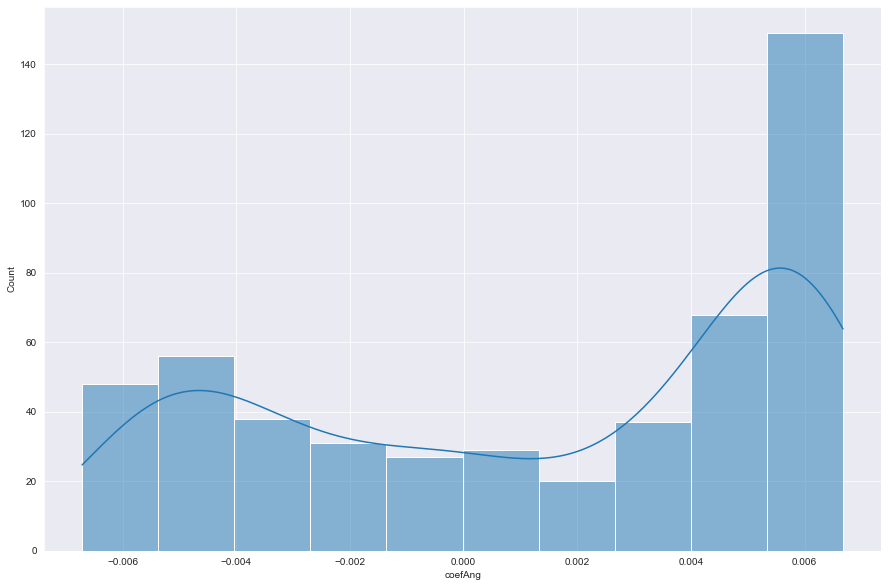

In [32]:
sns.histplot(data = regressAtivo, x="coefAng", kde=True);

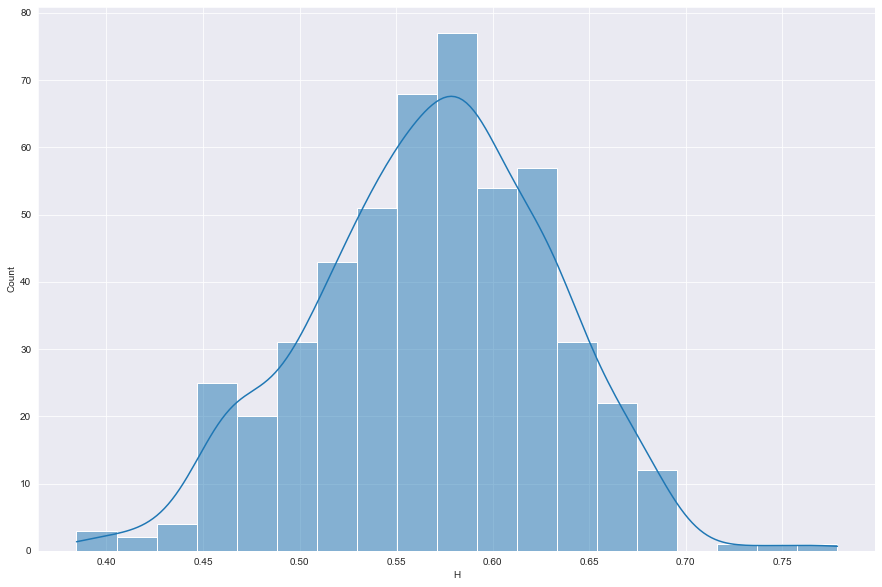

In [33]:
sns.histplot(data = regressAtivo, x="H", kde=True);

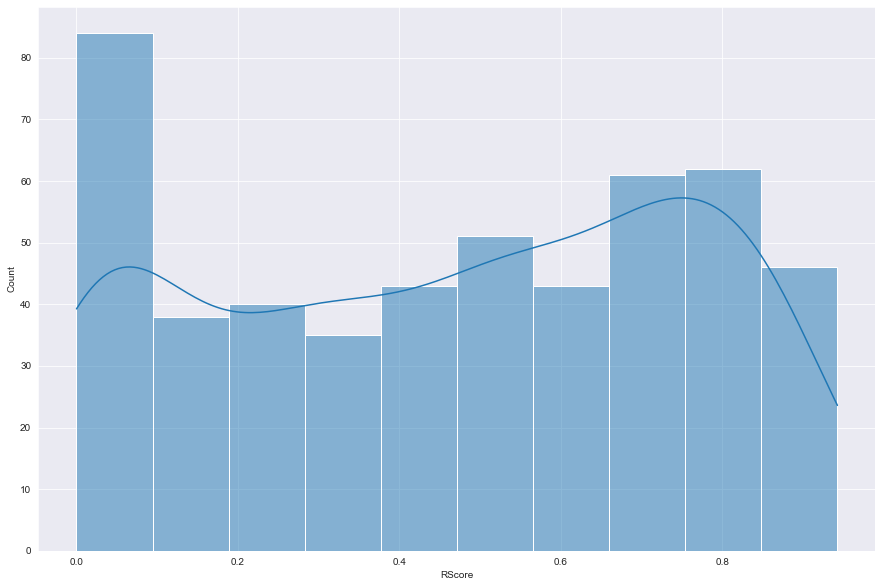

In [34]:
sns.histplot(data = regressAtivo, x="RScore", kde=True);

In [35]:
regressAtivo = regressAtivo[regressAtivo['H'] > 0.55]

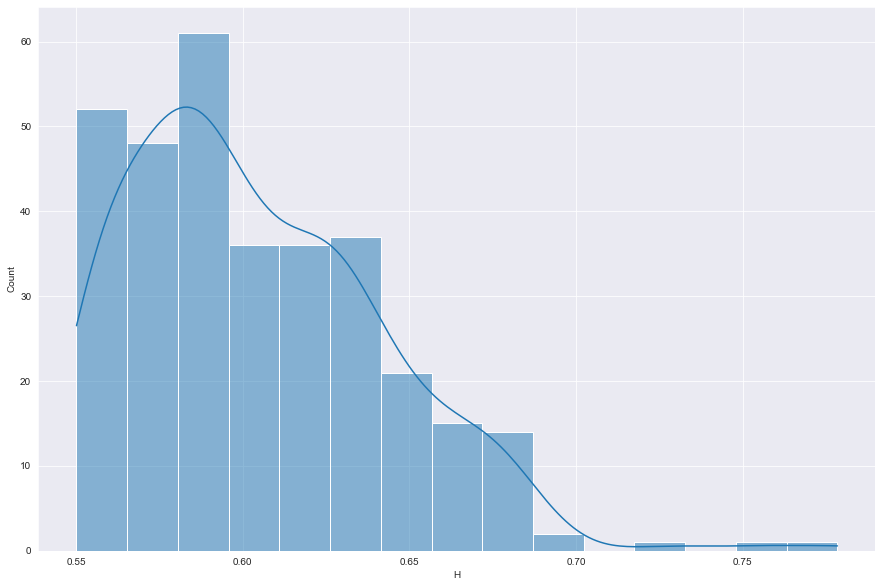

In [36]:
sns.histplot(data = regressAtivo, x="H", kde=True);

In [37]:
regressAtivo.sort_values(by='coefAng', ascending=False).head(20)

,coefAng,RScore,Setor,meanBeta,H,c,Group
ABT,0.006673,0.931092,HealthCare,-36.165702,0.577263,0.980759,3
CHD,0.006662,0.927279,ConsumerStaples,0.166738,0.646518,0.808667,3
MRK,0.00666,0.921631,HealthCare,5.119604,0.618963,0.919416,3
FE,0.006655,0.924671,Utilities,25.416685,0.60852,0.910072,3
CMG,0.00665,0.922127,ConsumerDiscretionary,-1.95119,0.676343,0.783197,3
RSG,0.006604,0.91127,Industrials,-5.738592,0.592361,0.933971,3
VRSK,0.006599,0.914736,Industrials,-83.458256,0.686657,0.794871,3
KEYS,0.006587,0.907401,InformationTechnology,-1.900076,0.639647,0.917544,3
VRSN,0.006584,0.906966,InformationTechnology,25.637666,0.605054,1.030898,3
STE,0.006583,0.904111,HealthCare,508.940731,0.631657,0.953984,3


In [38]:
choice = []

for group in range(quantAtivos):
    first = regressAtivo[regressAtivo['Group'] == group].sort_values(by='coefAng', ascending=False).index[group]
    choice.append(first)

In [39]:
tempAux = []

for index in regressAtivo.index:
    if index in choice:
        tempAux.append(True)
    
    else:
        tempAux.append(False)

In [40]:
wallet = regressAtivo[tempAux]
wallet

,coefAng,RScore,Setor,meanBeta,H,c,Group
ABMD,-0.000875,0.016045,HealthCare,3.017979,0.636978,0.956512,9
AMAT,-0.003346,0.234013,InformationTechnology,4.901339,0.597077,1.030579,5
BAC,-0.002044,0.08711,Financials,12.642764,0.566597,1.208011,8
EQR,0.006072,0.76549,RealEstate,-0.366652,0.620212,0.944631,7
FE,0.006655,0.924671,Utilities,25.416685,0.60852,0.910072,3
IDXX,0.005653,0.668865,HealthCare,-27.780562,0.62773,0.968854,0
JCI,0.002233,0.104227,Industrials,-4.221138,0.579661,1.12221,2
NKE,0.006155,0.805108,ConsumerDiscretionary,-28.446918,0.626529,0.909219,6
TXT,-0.003895,0.314972,Industrials,8.358541,0.597813,1.11519,4
WMB,-0.003455,0.2484,Energy,41.23118,0.62694,1.124167,1


In [41]:
std = df.loc[:, choice].std()

In [42]:
std.sum()

159.42220106582784

In [43]:
stdSum = std.sum()

In [44]:
std

IDXX    37.670412
WMB      2.324741
JCI      3.296819
FE       4.718700
TXT      7.442807
AMAT     7.638786
NKE      9.475337
EQR      7.863975
BAC      1.762398
ABMD    77.228226
dtype: float64

In [45]:
for ativo in choice:
    if wallet.loc[ativo, 'coefAng'] < 0:
        std[ativo] = stdSum * 0.04
    if std[ativo] > 0.2 * stdSum:
        std[ativo] = stdSum * 0.2

In [46]:
std

IDXX    31.884440
WMB      6.376888
JCI      3.296819
FE       4.718700
TXT      6.376888
AMAT     6.376888
NKE      9.475337
EQR      7.863975
BAC      6.376888
ABMD     6.376888
dtype: float64

In [47]:
distr = std / std.sum()

In [48]:
distr

IDXX    0.357755
WMB     0.071551
JCI     0.036991
FE      0.052946
TXT     0.071551
AMAT    0.071551
NKE     0.106317
EQR     0.088237
BAC     0.071551
ABMD    0.071551
dtype: float64

## Benchmark

In [49]:
future = SP500_close[SP500_close.index > '2019-10-20']

In [50]:
future.loc[:, choice]

,IDXX,WMB,JCI,FE,TXT,AMAT,NKE,EQR,BAC,ABMD
Dia,,,,,,,,,,
2019-10-21,278.880005,23.040001,42.389999,48.500000,47.209999,52.639999,96.220001,88.720001,31.020000,175.970001
2019-10-22,270.839996,23.209999,42.689999,48.360001,46.639999,51.980000,95.599998,88.440002,31.200001,170.830002
2019-10-23,267.929993,23.459999,42.369999,48.410000,46.790001,50.529999,92.320000,87.839996,31.420000,178.729996
2019-10-24,268.329987,23.219999,42.299999,48.290001,46.750000,55.070000,91.500000,87.580002,31.360001,179.960007
2019-10-25,268.290009,23.240000,42.560001,48.009998,47.259998,55.720001,90.919998,87.680000,31.719999,182.339996
...,...,...,...,...,...,...,...,...,...,...
2022-10-13,335.220001,30.410000,52.439999,37.119999,61.750000,79.419998,89.559998,63.939999,31.690001,258.079987
2022-10-14,324.640015,29.410000,50.840000,36.169998,59.840000,74.820000,87.550003,61.830002,31.700001,249.279999
2022-10-17,339.489990,29.959999,52.450001,36.919998,61.750000,74.410004,89.970001,64.180000,33.619999,257.869995


In [51]:
variationAssets = (future.loc[future.index[-1], choice] - future.loc[future.index[0], choice])
variationAssets

IDXX    56.609985
WMB      7.839998
JCI     10.020000
FE     -11.580002
TXT     14.630001
AMAT    24.620003
NKE     -7.650002
EQR    -25.090000
BAC      2.899998
ABMD    77.270004
dtype: float64

In [52]:
variationAssets.sum()

149.56998634338382

In [53]:
variationWallet = variationAssets * distr
variationWallet

IDXX    20.252497
WMB      0.560959
JCI      0.370655
FE      -0.613109
TXT      1.046791
AMAT     1.761585
NKE     -0.813323
EQR     -2.213857
BAC      0.207498
ABMD     5.528744
dtype: float64

In [54]:
variationWallet.sum()

26.088440029271013

In [55]:
wallet

,coefAng,RScore,Setor,meanBeta,H,c,Group
ABMD,-0.000875,0.016045,HealthCare,3.017979,0.636978,0.956512,9
AMAT,-0.003346,0.234013,InformationTechnology,4.901339,0.597077,1.030579,5
BAC,-0.002044,0.08711,Financials,12.642764,0.566597,1.208011,8
EQR,0.006072,0.76549,RealEstate,-0.366652,0.620212,0.944631,7
FE,0.006655,0.924671,Utilities,25.416685,0.60852,0.910072,3
IDXX,0.005653,0.668865,HealthCare,-27.780562,0.62773,0.968854,0
JCI,0.002233,0.104227,Industrials,-4.221138,0.579661,1.12221,2
NKE,0.006155,0.805108,ConsumerDiscretionary,-28.446918,0.626529,0.909219,6
TXT,-0.003895,0.314972,Industrials,8.358541,0.597813,1.11519,4
WMB,-0.003455,0.2484,Energy,41.23118,0.62694,1.124167,1


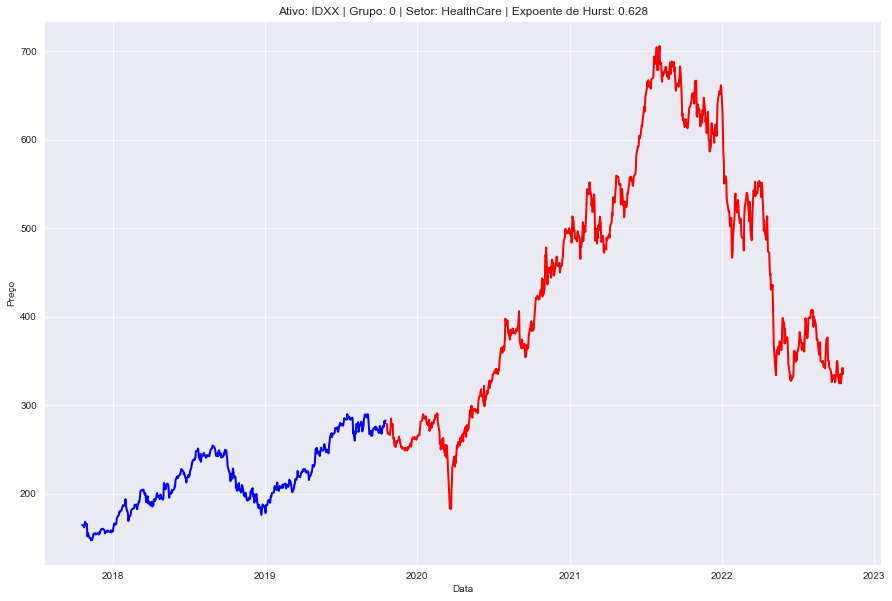

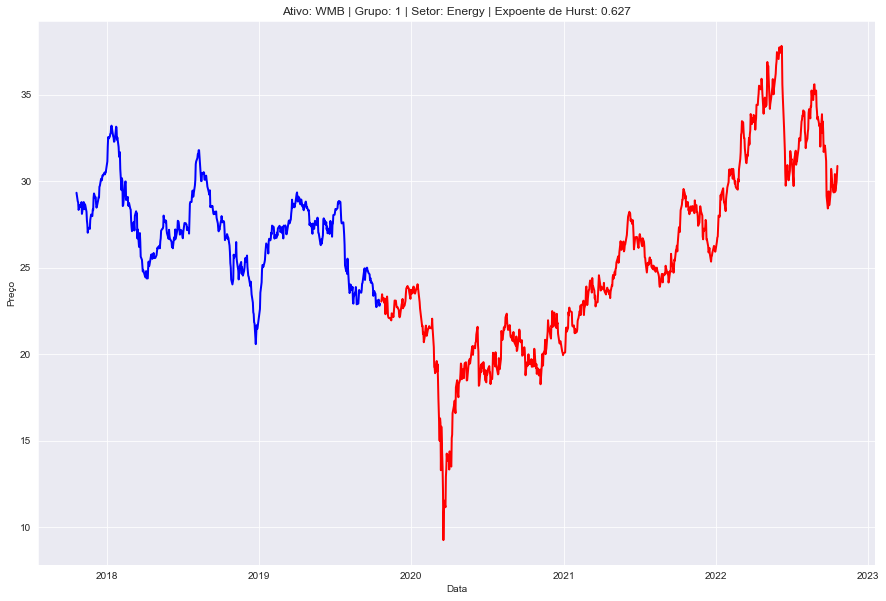

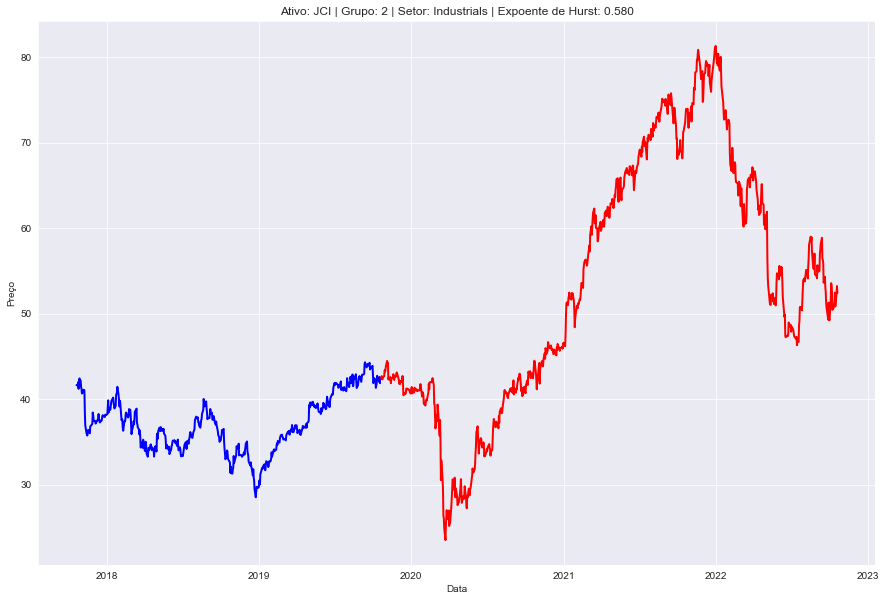

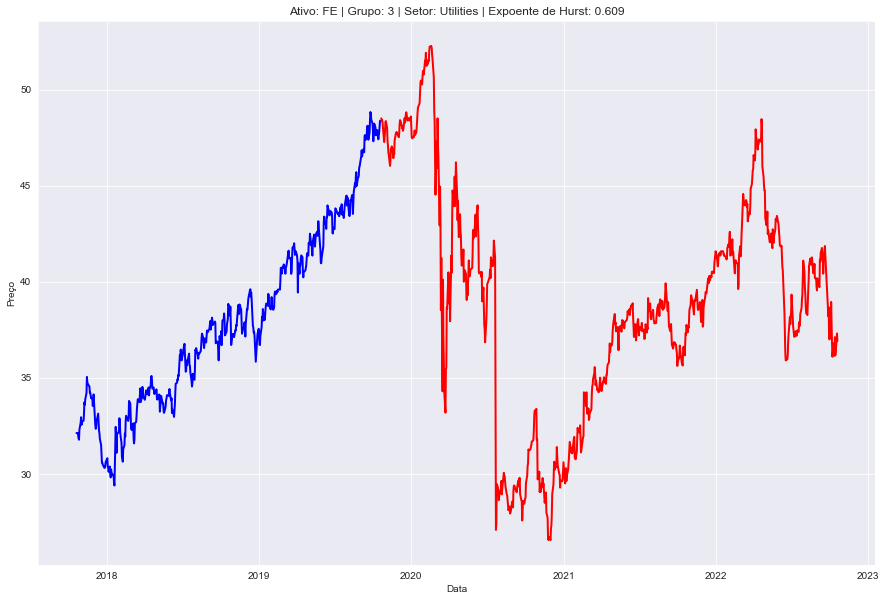

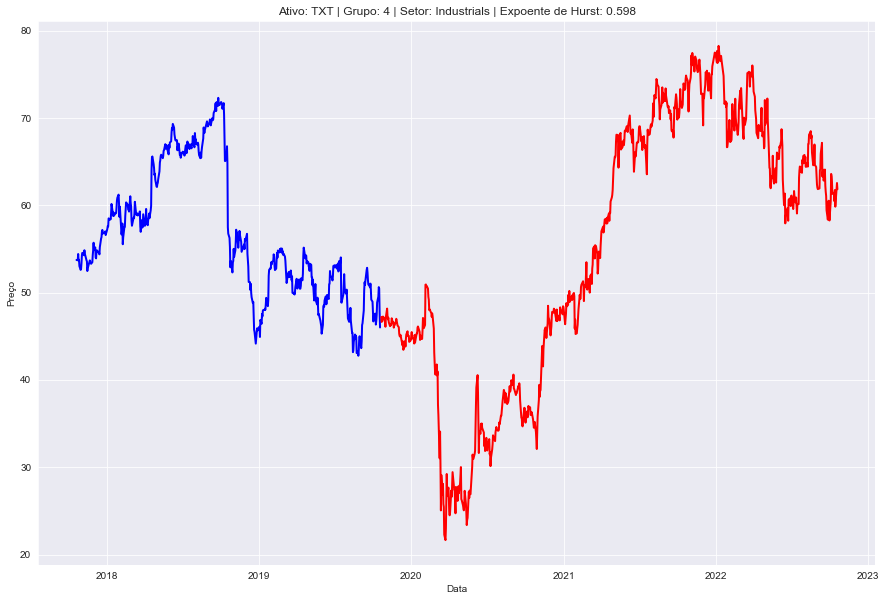

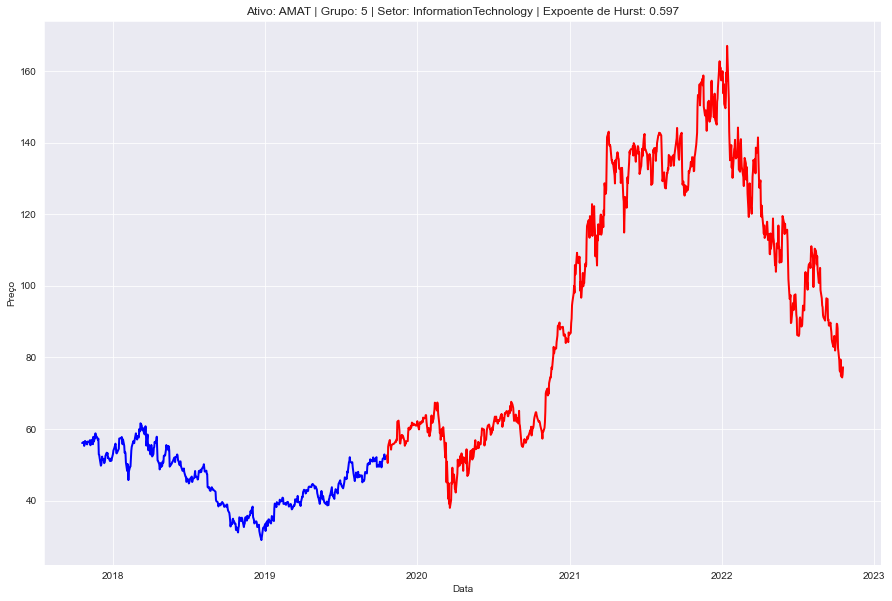

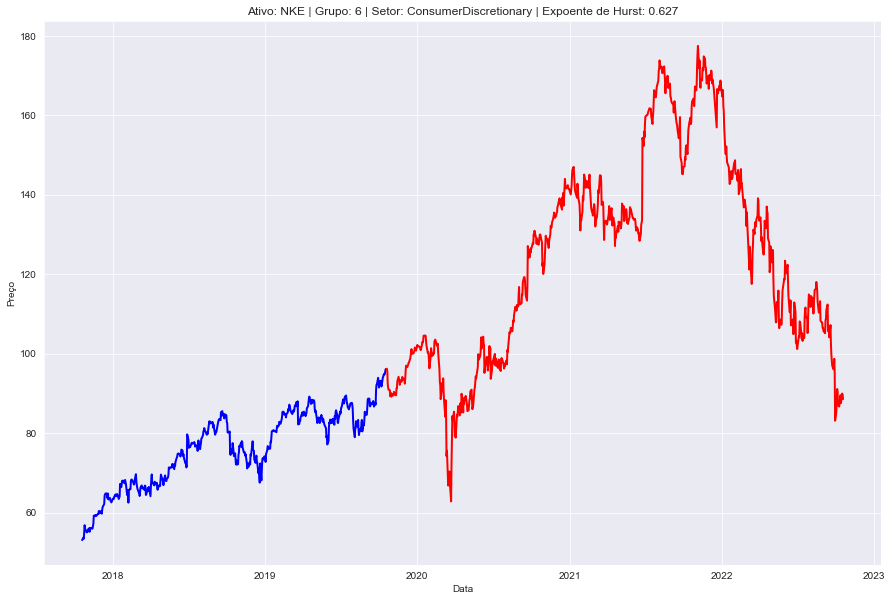

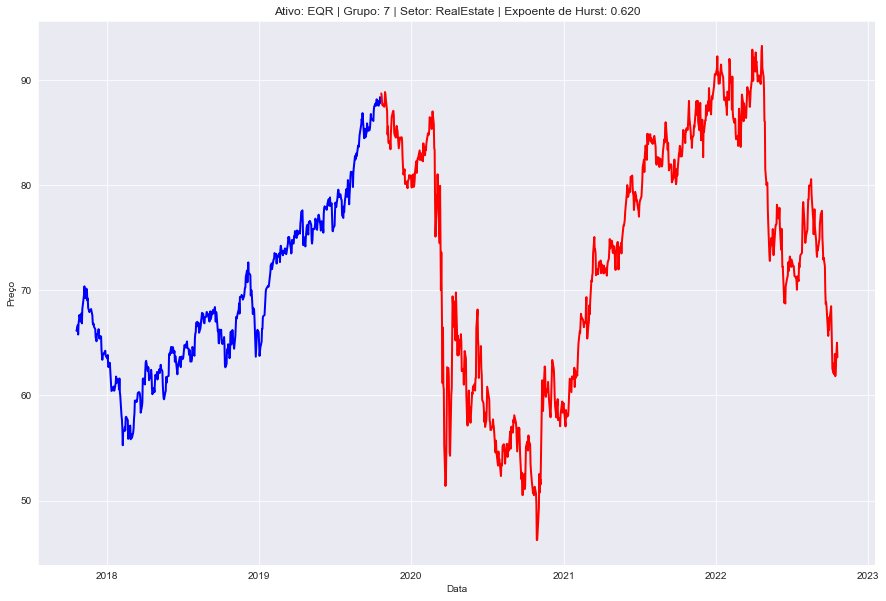

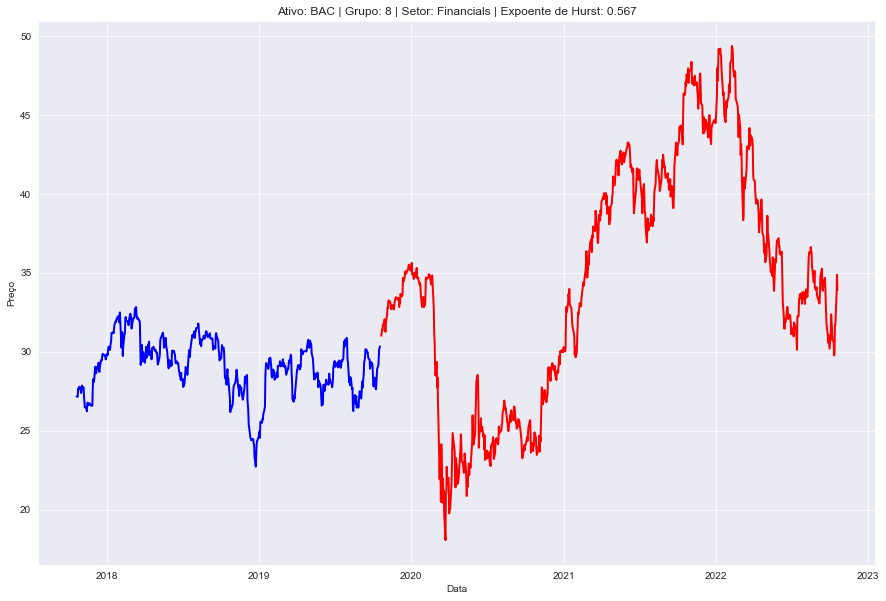

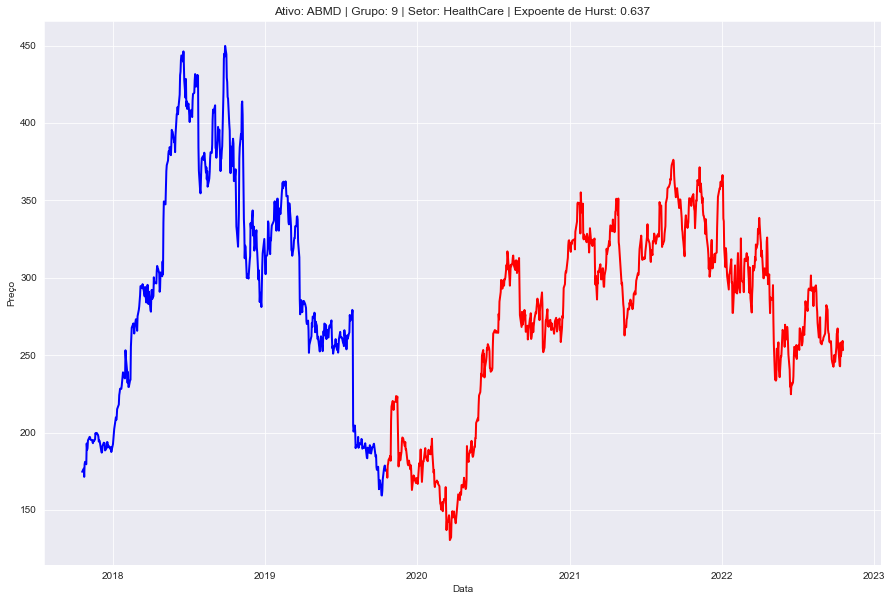

In [56]:
for ativo in choice:
    fig, ax = plt.subplots()
    ax.plot(df[ativo], linewidth=2.0, c = 'b')
    ax.plot(future[ativo], linewidth=2.0, c = 'r')
    
    ax.set_title("Ativo: {} | Grupo: {} | Setor: {} | Expoente de Hurst: {:.3f}"\
                 .format(ativo,
                         wallet.loc[ativo].Group,
                         wallet.loc[ativo].Setor,
                         wallet.loc[ativo].H
                        ))
    ax.set(xlabel='Data', ylabel = 'Preço')

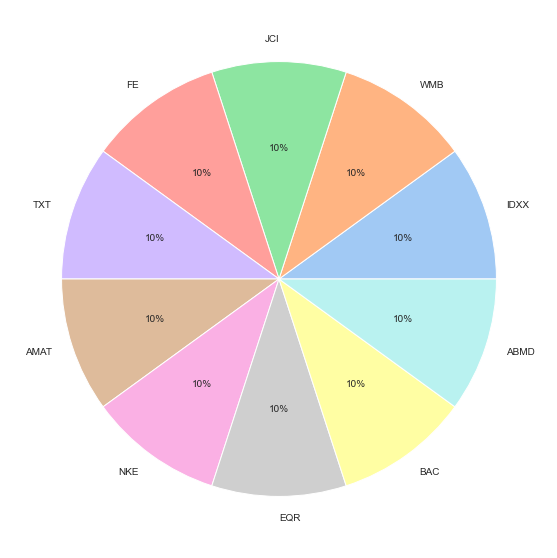

In [57]:
data = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

colors = sns.color_palette('pastel')[0:10]

#create pie chart
plt.pie(data, labels = choice, colors = colors, autopct='%.0f%%')
plt.show()

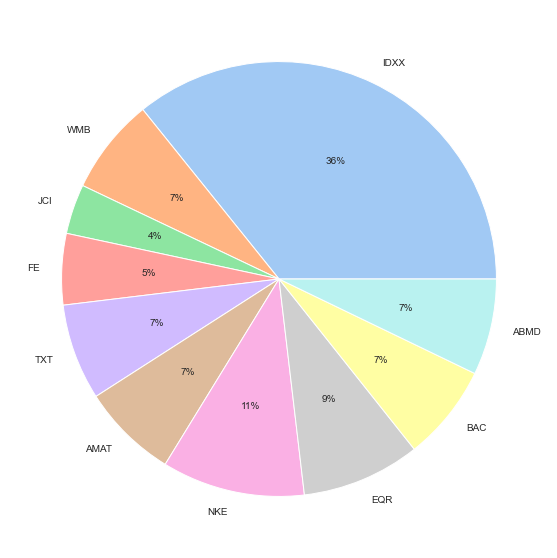

In [58]:
data = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

colors = sns.color_palette('pastel')[0:10]

#create pie chart
plt.pie(distr, labels = choice, colors = colors, autopct='%.0f%%')
plt.show()

In [59]:
future

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Dia,,,,,,,,,,,,,,,,,,,,,
2019-10-21,75.480003,28.620001,166.029999,60.127499,77.300003,86.660004,175.970001,81.650002,187.339996,266.839996,...,116.870003,64.290001,68.739998,55.060001,81.010002,112.309998,133.592239,205.779999,45.669998,126.449997
2019-10-22,74.690002,28.260000,165.979996,59.990002,77.870003,86.059998,170.830002,80.540001,182.720001,261.089996,...,115.699997,64.209999,69.089996,54.410000,81.269997,110.099998,130.893204,203.289993,48.080002,122.809998
2019-10-23,74.980003,28.290001,165.119995,60.794998,77.750000,85.650002,178.729996,81.269997,184.070007,261.320007,...,115.860001,64.440002,69.750000,54.400002,81.599998,109.269997,131.281555,206.889999,47.939999,121.800003
2019-10-24,75.000000,29.410000,166.809998,60.895000,76.800003,85.980003,179.960007,81.360001,185.000000,269.700012,...,117.110001,64.540001,69.089996,53.080002,81.980003,108.949997,130.961166,211.080002,47.509998,122.949997
2019-10-25,75.389999,30.860001,165.559998,61.645000,76.529999,86.800003,182.339996,81.650002,183.070007,270.980011,...,120.849998,63.639999,69.250000,53.080002,83.300003,109.099998,130.165054,219.080002,47.950001,124.360001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-13,127.900002,13.050000,171.580002,142.990005,142.919998,142.050003,258.079987,102.470001,257.459991,294.739990,...,57.099998,59.740002,101.870003,29.000000,88.339996,109.680000,109.430000,268.269989,50.570000,148.639999
2022-10-14,125.699997,13.110000,168.570007,138.380005,142.940002,140.600006,249.279999,100.910004,252.720001,287.940002,...,56.349998,58.860001,99.190002,28.480000,86.199997,106.769997,106.910004,255.610001,50.139999,145.399994
2022-10-17,130.559998,13.200000,169.860001,142.410004,144.410004,142.380005,257.869995,103.519997,262.220001,293.500000,...,57.299999,60.599998,100.620003,29.219999,90.550003,109.980003,110.510002,261.640015,51.880001,149.789993


In [61]:
growth = ((future.loc[future.index[-1], choice] / future.loc[future.index[0], choice]) -1) * 100

In [62]:
growthTable = future.loc[:, choice]
growthTable

,IDXX,WMB,JCI,FE,TXT,AMAT,NKE,EQR,BAC,ABMD
Dia,,,,,,,,,,
2019-10-21,278.880005,23.040001,42.389999,48.500000,47.209999,52.639999,96.220001,88.720001,31.020000,175.970001
2019-10-22,270.839996,23.209999,42.689999,48.360001,46.639999,51.980000,95.599998,88.440002,31.200001,170.830002
2019-10-23,267.929993,23.459999,42.369999,48.410000,46.790001,50.529999,92.320000,87.839996,31.420000,178.729996
2019-10-24,268.329987,23.219999,42.299999,48.290001,46.750000,55.070000,91.500000,87.580002,31.360001,179.960007
2019-10-25,268.290009,23.240000,42.560001,48.009998,47.259998,55.720001,90.919998,87.680000,31.719999,182.339996
...,...,...,...,...,...,...,...,...,...,...
2022-10-13,335.220001,30.410000,52.439999,37.119999,61.750000,79.419998,89.559998,63.939999,31.690001,258.079987
2022-10-14,324.640015,29.410000,50.840000,36.169998,59.840000,74.820000,87.550003,61.830002,31.700001,249.279999
2022-10-17,339.489990,29.959999,52.450001,36.919998,61.750000,74.410004,89.970001,64.180000,33.619999,257.869995


In [63]:
for ativo in choice:
    growthTable[ativo] = (growthTable[ativo] / growthTable[ativo][0]) * 100 * distr[ativo]

In [64]:
growthTable

,IDXX,WMB,JCI,FE,TXT,AMAT,NKE,EQR,BAC,ABMD
Dia,,,,,,,,,,
2019-10-21,35.775485,7.155097,3.699150,5.294550,7.155097,7.155097,10.631668,8.823662,7.155097,7.155097
2019-10-22,34.744091,7.207890,3.725329,5.279267,7.068709,7.065387,10.563162,8.795814,7.196616,6.946100
2019-10-23,34.370788,7.285528,3.697404,5.284725,7.091443,6.868295,10.200744,8.736141,7.247361,7.267321
2019-10-24,34.422100,7.210996,3.691296,5.271626,7.085380,7.485395,10.110139,8.710283,7.233522,7.317334
2019-10-25,34.416972,7.217207,3.713985,5.241059,7.162675,7.573747,10.046053,8.720228,7.316559,7.414107
...,...,...,...,...,...,...,...,...,...,...
2022-10-13,43.002933,9.443858,4.576160,4.052241,9.358764,10.795171,9.895782,6.359163,7.309640,10.493762
2022-10-14,41.645704,9.133307,4.436536,3.948534,9.069287,10.169916,9.673691,6.149313,7.311946,10.135947
2022-10-17,43.550699,9.304110,4.577032,4.030408,9.358764,10.114187,9.941085,6.383032,7.754815,10.485224


[Text(0.5, 0, 'Data'), Text(0, 0.5, 'Crescimento')]

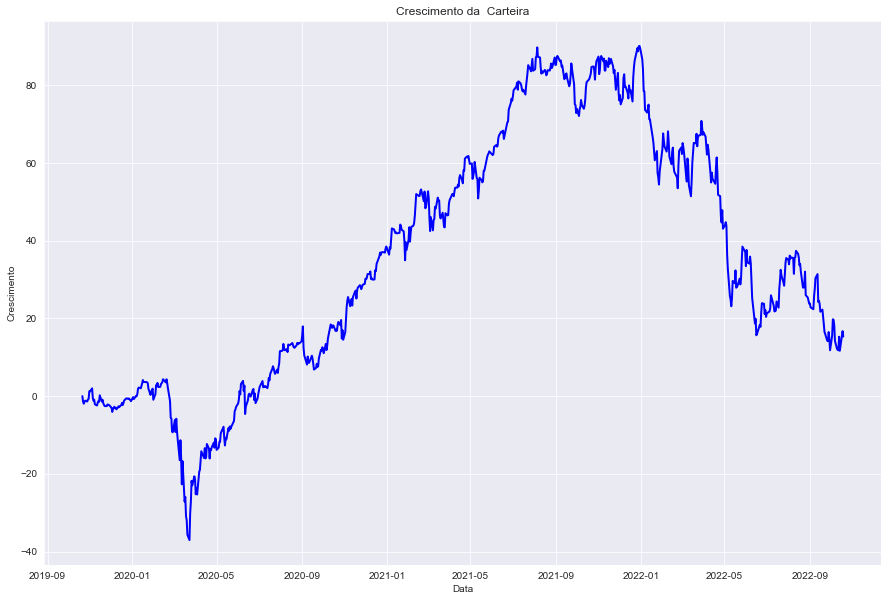

In [65]:
fig, ax = plt.subplots()
ax.plot(growthTable.sum(axis = 1) - 100, linewidth=2.0, c = 'b')

    
ax.set_title('Crescimento da  Carteira')
ax.set(xlabel='Data', ylabel = 'Crescimento')